# Load Data
We will load all the data except 219 V columns that were determined redundant by correlation analysis

In [1]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30',
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

In [2]:
cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [4]:
X_train = pd.read_csv(r"D:\Sharif University of Tech\Data\Fraud Detection\XGB Fraud\Data\train_transaction.csv",index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv(r'D:\Sharif University of Tech\Data\Fraud Detection\XGB Fraud\Data\train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

In [7]:
X_train

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000.0,0,86400.0,68.500000,W,13926.0,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001.0,0,86401.0,29.000000,W,2755.0,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002.0,0,86469.0,59.000000,W,4663.0,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003.0,0,86499.0,50.000000,W,18132.0,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004.0,0,86506.0,50.000000,H,4497.0,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535.0,0,15811047.0,49.000000,W,6550.0,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536.0,0,15811049.0,39.500000,W,10444.0,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537.0,0,15811079.0,30.950001,W,12037.0,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
X_test = pd.read_csv(r"D:\Sharif University of Tech\Data\Fraud Detection\XGB Fraud\Data\test_transaction.csv",index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv(r"D:\Sharif University of Tech\Data\Fraud Detection\XGB Fraud\Data\test_identity.csv",index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

In [10]:
X_test

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549.0,18403224.0,31.950001,W,10409.0,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663550.0,18403264.0,49.000000,W,4272.0,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663551.0,18403310.0,171.000000,W,4476.0,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663552.0,18403310.0,284.950012,W,10989.0,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663553.0,18403316.0,67.949997,W,18018.0,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170235.0,34214280.0,94.679001,C,13832.0,375.0,185.0,mastercard,224.0,debit,284.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4170236.0,34214288.0,12.173000,C,3154.0,408.0,185.0,mastercard,224.0,debit,NaN,...,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
4170237.0,34214328.0,49.000000,W,16661.0,490.0,150.0,visa,226.0,debit,327.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()

In [13]:
X_train.shape

(590540, 213)

In [14]:
X_test.shape

(506691, 213)

# Normalize D Columns
The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is `D15n = Transaction_Day - D15` and `Transaction_Day = TransactionDT/(24*60*60)`. Afterward we multiple this number by negative one.

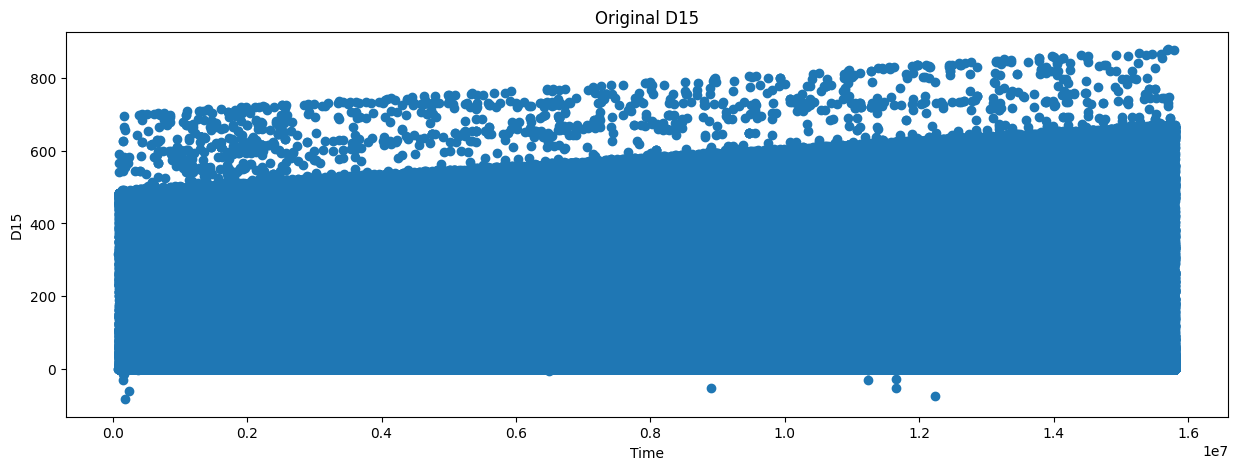

In [15]:
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [16]:
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

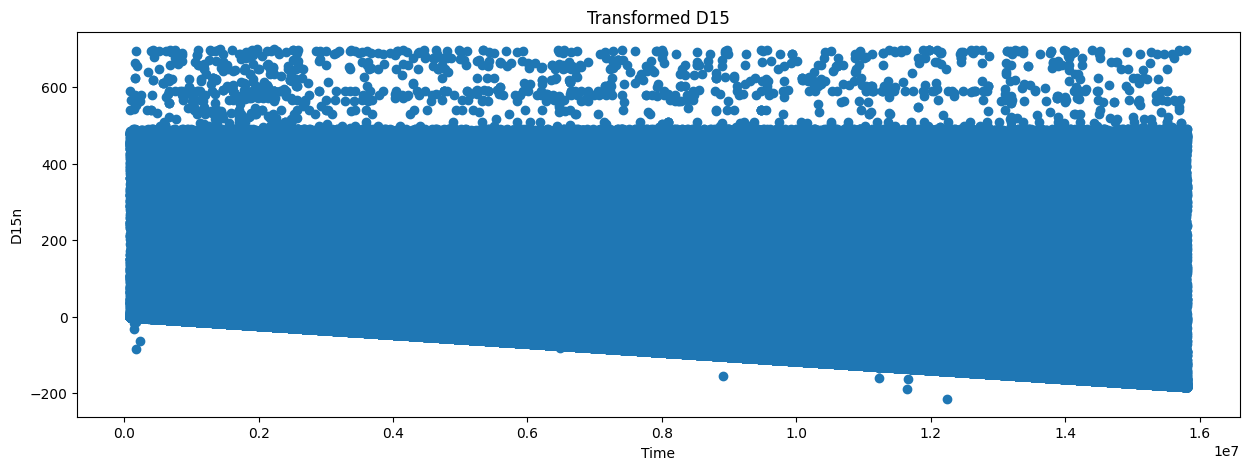

In [17]:
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [20]:
for i,f in enumerate(X_train.columns):

    if (np.str_(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'):
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')


    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\1195305502.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[f].fillna(-1,inplace=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\1195305502.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

# Encoding Functions
Below are 5 encoding functions. (1) `encode_FE` does frequency encoding where it combines train and test first and then encodes. (2) `encode_LE` is a label encoded for categorical features (3) `encode_AG` makes aggregated features such as aggregated mean and std (4) `encode_CB` combines two columns (5) `encode_AG2` makes aggregated features where it counts how many unique values of one feature is within a group. For more explanation about feature engineering

In [22]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [23]:
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000:
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

In [24]:
# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test,
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)

                print("'"+new_col_name+"'",', ',end='')

In [25]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

In [26]:
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

# Feature Engineering
We will now engineer features. All of these features where chosen because each increases local validation. The procedure for engineering features is as follows. First you think of an idea and create a new feature. Then you add it to your model and evaluate whether local validation AUC increases or decreases. If AUC increases keep the feature, otherwise discard the feature.

In [28]:
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')

In [29]:
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])

addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [30]:
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\4190363297.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\4190363297.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1 , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\4190363297.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\4190363297.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1_P_emaildomain , 

In [31]:
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

card1_addr1_FE , card1_addr1_P_emaildomain_FE , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [32]:
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'D9_card1_std' , 'D9_card1_addr1_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D9_card1_addr1_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'D9_card1_addr1_P_emaildomain_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'D11_card1_std' , 'D11_card1_addr1_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D11_card1_addr1_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

# Feature Selection - Time Consistency
We added 28 new feature above. We have already removed 219 V Columns from correlation analysis done [here][1]. So we currently have 242 features now. We will now check each of our 242 for "time consistency". We will build 242 models. Each model will be trained on the first month of the training data and will only use one feature. We will then predict the last month of the training data. We want both training AUC and validation AUC to be above `AUC = 0.5`. It turns out that 19 features fail this test so we will remove them. Additionally we will remove 7 D columns that are mostly NAN.

In [34]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

In [35]:
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

The new Fearures would then be :

In [38]:
cols

['TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V160',
 'V162',
 'V165',
 'V166',
 'V169',
 'V171',
 'V173',
 'V175',
 'V176',
 'V178',
 'V180',
 'V182',
 'V185',
 'V187',
 'V188',
 'V198',
 'V203',
 'V205',
 'V207',
 'V209

# Local Validation
For this competition, we used time based local validation. I evaluated features by training on the first 75% of the data and predicting the last 25% of the data. Konstantin had a slightly different local validaiton. He trained on the first 4 months, skipped a month, and predicted the last month. Our current XGB model with 216 features achieves AUC = 0.9363 on Chris' local validation and AUC = 0.9241 on Konstantin's local validation.

In [39]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [40]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

XGBoost version: 2.0.3


In [41]:
if BUILD95:
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist'
        # USE GPU
        tree_method='gpu_hist'
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT],
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:17:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.79247
[50]	validation_0-auc:0.88770
[100]	validation_0-auc:0.90468
[150]	validation_0-auc:0.91822
[200]	validation_0-auc:0.92654
[250]	validation_0-auc:0.93190
[300]	validation_0-auc:0.93446
[350]	validation_0-auc:0.93545
[400]	validation_0-auc:0.93580
[450]	validation_0-auc:0.93613
[500]	validation_0-auc:0.93622
[550]	validation_0-auc:0.93614
[586]	validation_0-auc:0.93584


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


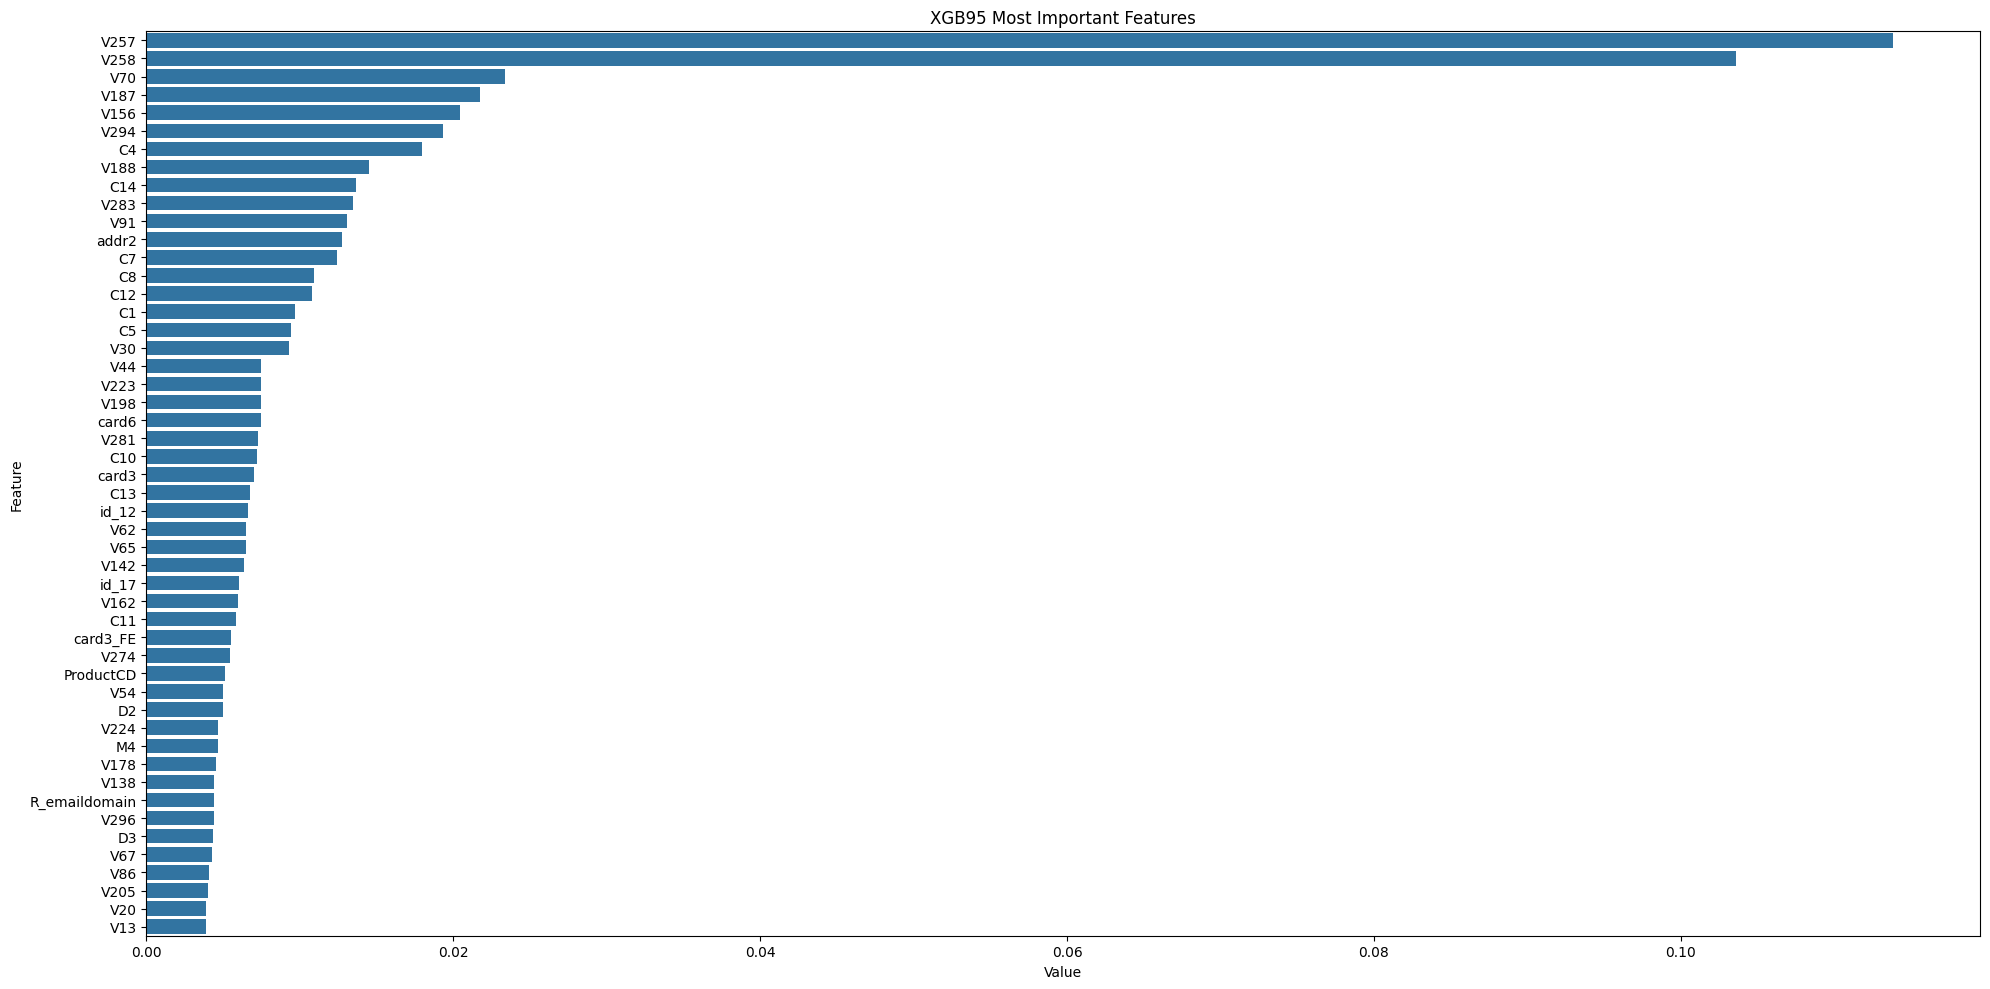

In [42]:
if BUILD95:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

# Predict test.csv
We will predict `test.csv` using GroupKFold with months as groups. The training data are the months December 2017, January 2018, February 2018, March 2018, April 2018, and May 2018. We refer to these months as 12, 13, 14, 15, 16, 17. Fold one in GroupKFold will train on months 13 thru 17 and predict month 12. Note that the only purpose of month 12 is to tell XGB when to `early_stop` we don't actual care about the backwards time predictions. The model trained on months 13 thru 17 will also predict `test.csv` which is forward in time.
  
Note that we use local validation to determine features but GroupKFold to predict `test.csv`. Many other prediction schemes were tried but GroupKFold performed best.

In [43]:
import datetime
START_DATE = datetime.datetime.strptime('2024-04-06', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3660503656.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))


In [44]:
X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3068421984.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))


In [45]:
if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist'
        )
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)

        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB95 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 88
 rows of train = 479991 rows of holdout = 110549


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:18:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.77871
[100]	validation_0-auc:0.88694
[200]	validation_0-auc:0.90594
[300]	validation_0-auc:0.91536
[400]	validation_0-auc:0.91942
[500]	validation_0-auc:0.92111
[600]	validation_0-auc:0.92155
[700]	validation_0-auc:0.92162
[800]	validation_0-auc:0.92159
[879]	validation_0-auc:0.92132


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.


Fold 1 withholding month 91
 rows of train = 490577 rows of holdout = 99963


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.82379
[100]	validation_0-auc:0.91708
[200]	validation_0-auc:0.93777
[300]	validation_0-auc:0.94407
[400]	validation_0-auc:0.94599
[500]	validation_0-auc:0.94678
[600]	validation_0-auc:0.94655
[700]	validation_0-auc:0.94613
[704]	validation_0-auc:0.94609


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 2 withholding month 89
 rows of train = 491429 rows of holdout = 99111


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.79620
[100]	validation_0-auc:0.90567
[200]	validation_0-auc:0.92676
[300]	validation_0-auc:0.93349
[400]	validation_0-auc:0.93575
[500]	validation_0-auc:0.93632
[600]	validation_0-auc:0.93676
[700]	validation_0-auc:0.93686
[800]	validation_0-auc:0.93678
[872]	validation_0-auc:0.93663


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 3 withholding month 90
 rows of train = 499083 rows of holdout = 91457


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.79799
[100]	validation_0-auc:0.92592
[200]	validation_0-auc:0.94514
[300]	validation_0-auc:0.95127
[400]	validation_0-auc:0.95280
[500]	validation_0-auc:0.95276
[600]	validation_0-auc:0.95260
[656]	validation_0-auc:0.95250


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 4 withholding month 92
 rows of train = 501065 rows of holdout = 89475


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.80599
[100]	validation_0-auc:0.92153
[200]	validation_0-auc:0.94461
[300]	validation_0-auc:0.95352
[400]	validation_0-auc:0.95645
[500]	validation_0-auc:0.95708
[600]	validation_0-auc:0.95738
[700]	validation_0-auc:0.95722
[800]	validation_0-auc:0.95685
[860]	validation_0-auc:0.95704


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 5 withholding month 93
 rows of train = 490555 rows of holdout = 99985


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.79821
[100]	validation_0-auc:0.91172
[200]	validation_0-auc:0.93195
[300]	validation_0-auc:0.93972
[400]	validation_0-auc:0.94197
[500]	validation_0-auc:0.94268
[600]	validation_0-auc:0.94281
[700]	validation_0-auc:0.94267
[800]	validation_0-auc:0.94257
[833]	validation_0-auc:0.94237


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


####################
XGB95 OOF CV= 0.9436591000731143


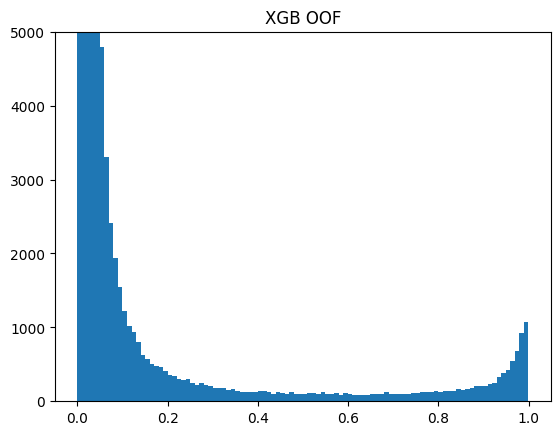

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\545610673.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['oof'] = oof
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\545610673.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train.reset_index(inplace=True)


In [46]:
if BUILD95:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_95.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)

else: X_train['oof'] = 0

# The Magic Feature - UID
We will now create and use the MAGIC FEATURES. First we create a UID which will help our model find clients (credit cards). This UID isn't perfect. Many UID values contain 2 or more clients inside. However our model will detect this and by adding more splits with its trees, it will split these UIDs and find the single clients (credit cards).

In [48]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\799391299.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['day'] = X_train.TransactionDT / (24*60*60)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\799391299.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)


In [49]:
X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\476726372.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['day'] = X_test.TransactionDT / (24*60*60)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\476726372.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)


# Group Aggregation Features
For our model to use the new UID, we need to make lots of aggregated group features. We will add 47 new features! The pictures in the introduction to this notebook explain why this works. Note that after aggregation, we remove UID from our model. We don't use UID directly.

In [50]:
encode_FE(X_train,X_test,['uid'])
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\2156415602.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)


uid_FE , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'TransactionAmt_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'TransactionAmt_uid_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D4_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D4_uid_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D9_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D9_uid_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D10_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D10_uid_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D15_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D15_uid_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C1_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C2_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C4_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C5_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C6_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C7_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C8_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C9_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C10_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C11_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C12_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C13_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C14_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M1_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M2_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M3_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M4_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M5_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M6_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M7_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M8_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'M9_uid_mean' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_P_emaildomain_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_dist1_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_DT_M_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_id_02_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_cents_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3787020938.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'C14_uid_std' , 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_C13_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_V314_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_V127_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_V136_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_V309_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


uid_V307_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')


uid_V320_ct, 

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3045995840.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')


In [51]:
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3593043588.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\3593043588.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')


In [52]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    cols.remove(c)

# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [53]:
cols

['TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V160',
 'V162',
 'V165',
 'V166',
 'V169',
 'V171',
 'V173',
 'V175',
 'V176',
 'V178',
 'V180',
 'V182',
 'V185',
 'V187',
 'V188',
 'V198',
 'V203',
 'V205',
 'V207',
 'V209

In [54]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [55]:
if BUILD96:
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist'
        tree_method='gpu_hist'
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT],
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.81277
[50]	validation_0-auc:0.90557
[100]	validation_0-auc:0.92224
[150]	validation_0-auc:0.93355
[200]	validation_0-auc:0.93964
[250]	validation_0-auc:0.94374
[300]	validation_0-auc:0.94567
[350]	validation_0-auc:0.94691
[400]	validation_0-auc:0.94696
[450]	validation_0-auc:0.94724
[500]	validation_0-auc:0.94708
[550]	validation_0-auc:0.94689
[570]	validation_0-auc:0.94686


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


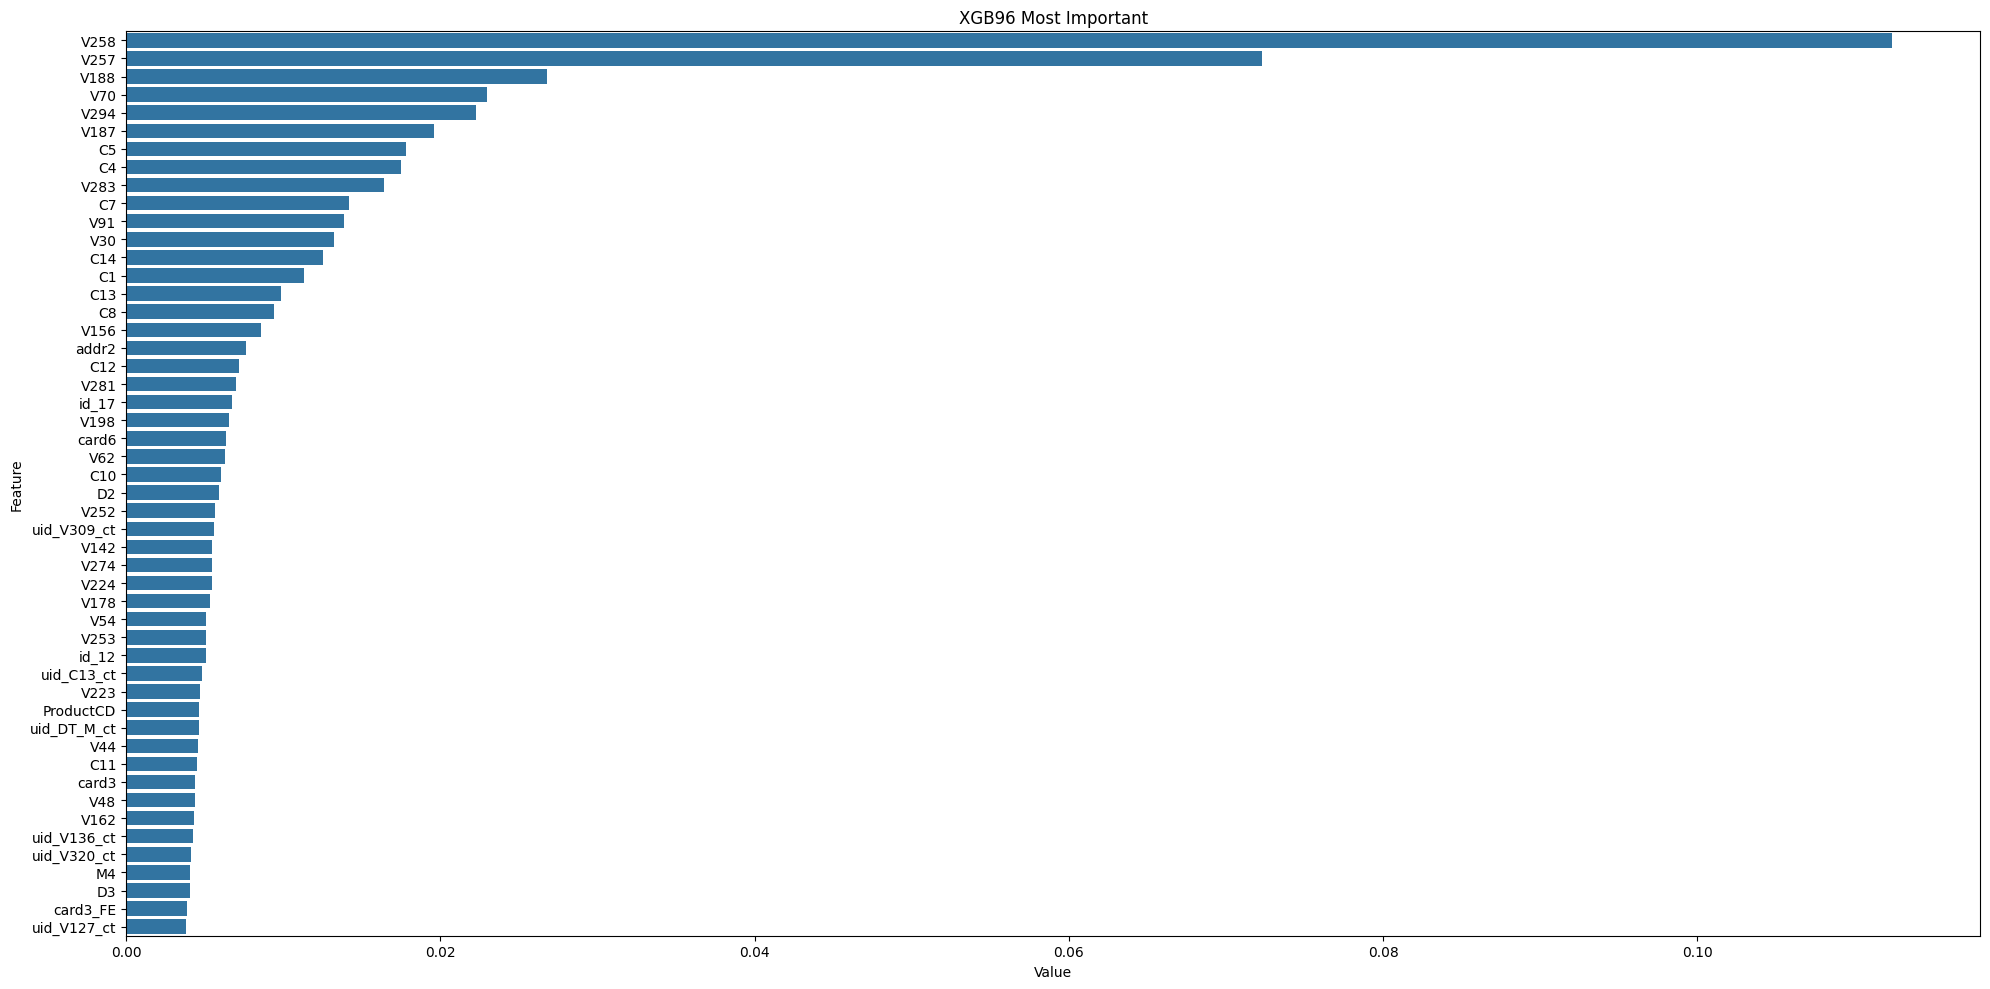

In [56]:
if BUILD96:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB96 Most Important')
    plt.tight_layout()
    plt.show()

    del clf, h; x=gc.collect()

In [57]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist'
        )
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)

        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 88
 rows of train = 479991 rows of holdout = 110549


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.79914
[100]	validation_0-auc:0.90834
[200]	validation_0-auc:0.92389
[300]	validation_0-auc:0.92919
[400]	validation_0-auc:0.93254
[500]	validation_0-auc:0.93393
[600]	validation_0-auc:0.93465
[700]	validation_0-auc:0.93555
[800]	validation_0-auc:0.93549
[900]	validation_0-auc:0.93545
[950]	validation_0-auc:0.93536


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 1 withholding month 91
 rows of train = 490577 rows of holdout = 99963


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.82996
[100]	validation_0-auc:0.93734
[200]	validation_0-auc:0.95342
[300]	validation_0-auc:0.95902
[400]	validation_0-auc:0.96017
[500]	validation_0-auc:0.96031
[600]	validation_0-auc:0.96020
[678]	validation_0-auc:0.95983


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 2 withholding month 89
 rows of train = 491429 rows of holdout = 99111


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.80980
[100]	validation_0-auc:0.92903
[200]	validation_0-auc:0.94672
[300]	validation_0-auc:0.95257
[400]	validation_0-auc:0.95402
[500]	validation_0-auc:0.95485
[600]	validation_0-auc:0.95522
[700]	validation_0-auc:0.95526
[800]	validation_0-auc:0.95542
[900]	validation_0-auc:0.95547
[1000]	validation_0-auc:0.95522
[1085]	validation_0-auc:0.95520


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 3 withholding month 90
 rows of train = 499083 rows of holdout = 91457


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.79830
[100]	validation_0-auc:0.94378
[200]	validation_0-auc:0.95869
[300]	validation_0-auc:0.96351
[400]	validation_0-auc:0.96486
[500]	validation_0-auc:0.96493
[600]	validation_0-auc:0.96510
[700]	validation_0-auc:0.96508
[800]	validation_0-auc:0.96501
[822]	validation_0-auc:0.96499


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 4 withholding month 92
 rows of train = 501065 rows of holdout = 89475


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.83139
[100]	validation_0-auc:0.94180
[200]	validation_0-auc:0.96045
[300]	validation_0-auc:0.96710
[400]	validation_0-auc:0.96914
[500]	validation_0-auc:0.96982
[600]	validation_0-auc:0.97024
[700]	validation_0-auc:0.97024
[800]	validation_0-auc:0.97033
[854]	validation_0-auc:0.97021


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 5 withholding month 93
 rows of train = 490555 rows of holdout = 99985


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.82993
[100]	validation_0-auc:0.92608
[200]	validation_0-auc:0.94331
[300]	validation_0-auc:0.94986
[400]	validation_0-auc:0.95164
[500]	validation_0-auc:0.95214
[600]	validation_0-auc:0.95193
[700]	validation_0-auc:0.95169
[751]	validation_0-auc:0.95170


d:\Sharif University of Tech\Data\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


####################
XGB96 OOF CV= 0.956466495835511


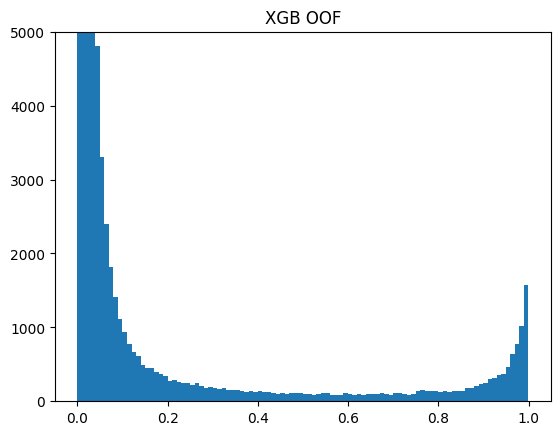

C:\Users\Acer\AppData\Local\Temp\ipykernel_15988\4022895427.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train.reset_index(inplace=True)


In [58]:
if BUILD96:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)